<a href="https://colab.research.google.com/github/xbadiam/Forecasting/blob/main/notebooks/Antidiabetic_drug_prescriptions/data/Antidiabetic_drug_prescriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting the number of antidiabetic drug prescriptions in Australia

The objective of the project is forecasting the number of antidiabetic drug prescriptions in Australia, from 1991 to 2008. In a professional setting, solving this problem would allow us to gauge the production of antidiabetic drugs, such as to produce enough to meet the demand and but also avoid overproduction. The data we'll use was recorded by the Australian Health Insurance Commission.

In [1]:
!rm -rf /content/Forecasting/notebooks/Antidiabetic_drug_prescriptions

#notebooks/Antidiabetic_drug_prescriptions/Antidiabetic_drug_prescriptions_Australia.ipynb


! git clone https://github.com/xbadiam/Forecasting.git

Cloning into 'Forecasting'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (83/83), done.
Receiving objects: 100% (93/93), 233.90 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (15/15), done.
remote: Total 93 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('../content/Forecasting/notebooks/Antidiabetic_drug_prescriptions/data/AusAntidiabeticDrug.csv')
df.head(10)

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [5]:
df.tail(10)

,ds,y
194,2007-09-01,22.930357
195,2007-10-01,23.263340
196,2007-11-01,25.250030
197,2007-12-01,25.806090
198,2008-01-01,29.665356
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [4]:
df.shape

(204, 2)

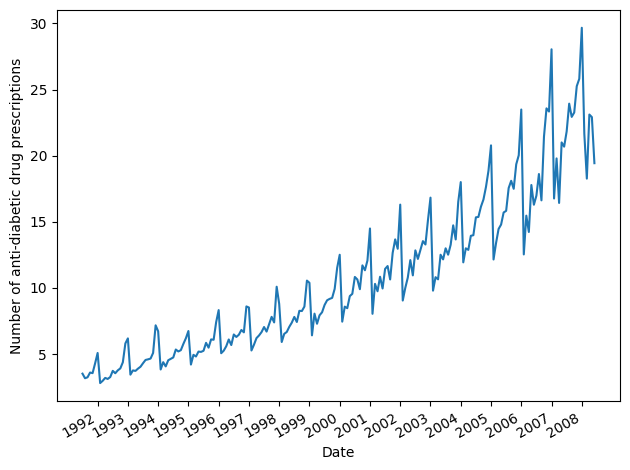

In [6]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

We'll see a clear trend in the time series, as the number of prescriptions
increases over time. Furthermore, you’ll observe strong seasonality, as each year seems to start at a low value and end at a high value. By now, you should intuitively know which model is potentially the most suitable for solving this problem.

To solve this problem, refer to the following steps:

1. The objective is to forecast 12 months of antidiabetic drug prescriptions. Use the last 36 months of the dataset as a test set to allow for rolling forecasts.

2. Visualize the time series.

3. Use time series decomposition to extract the trend and seasonal components.

4. Model the series with the usual steps: Apply transformations to make it stationary. Set the values of d and D. Set the value of m.

5. Perform rolling forecasts of 12 months on the test set.

6. Visualize your forecasts.

## Exploration

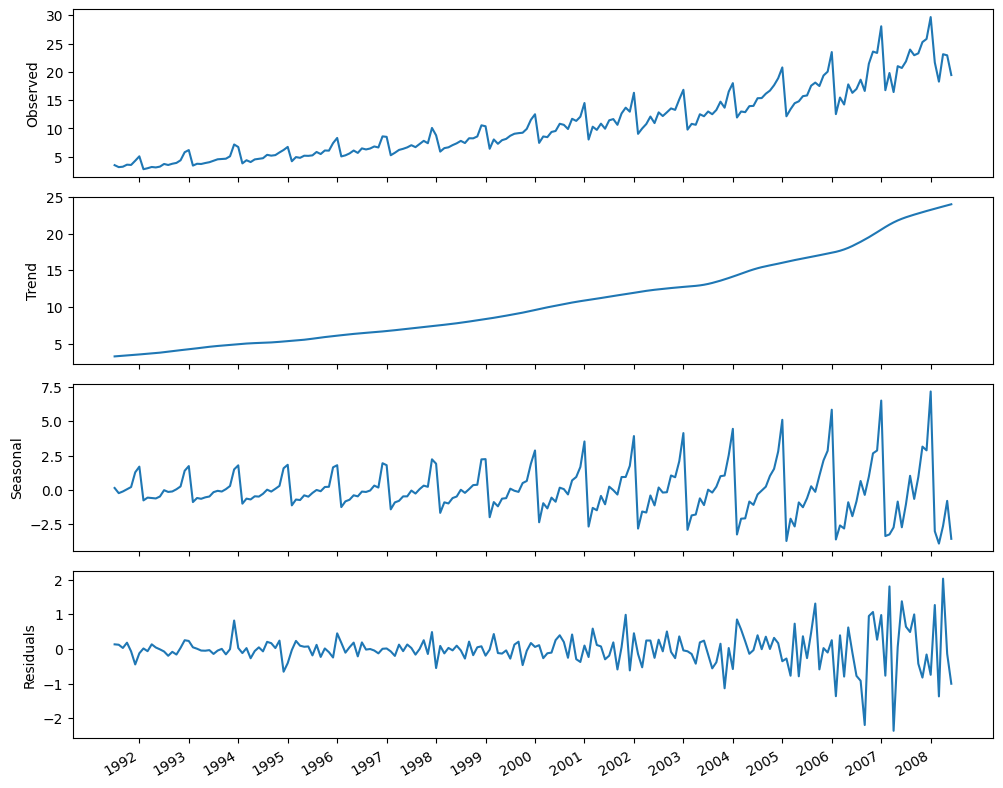

In [7]:
# Column y holds the number of monthly antidiabetic prescriptions. Also, the period
# is set to 12, since we have monthly data.
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()